## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
torch.cuda.set_device(0)

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [6]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f01950.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_05970.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08400.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009180_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f01110_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_08115_P.png')]

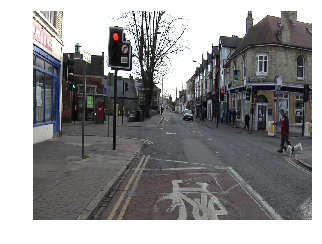

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

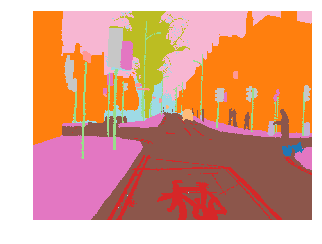

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [14]:
size = src_size//2
bs=8

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

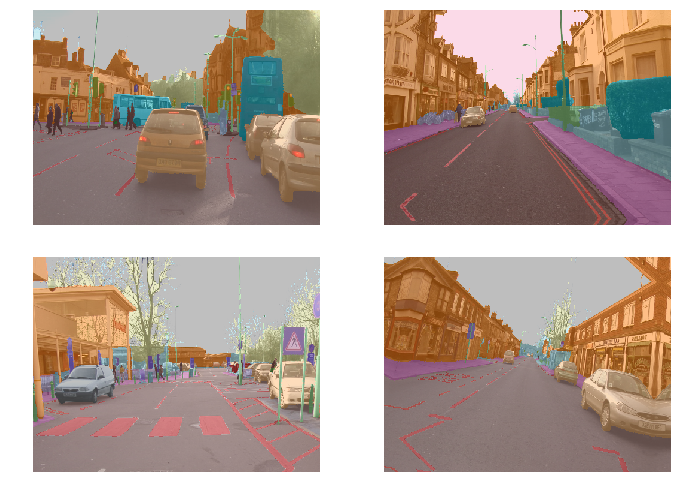

In [17]:
data.show_batch(2, figsize=(10,7))

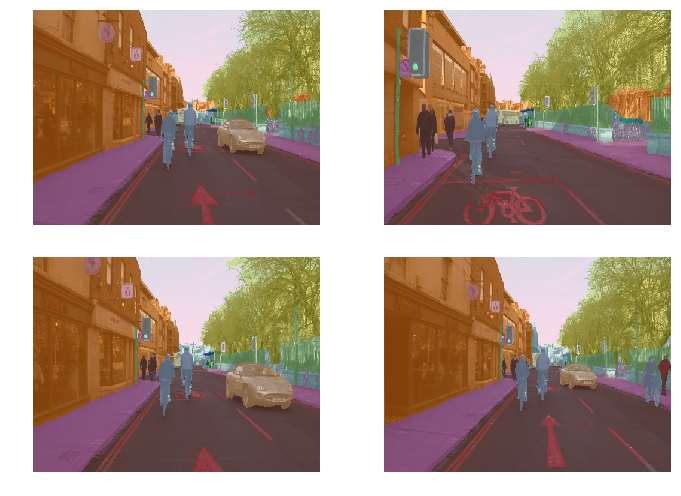

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
wd=1e-2

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


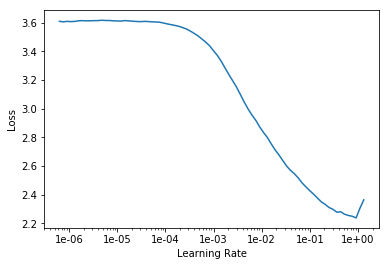

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,2.231539,1.409677,0.732861
2,1.266339,0.774381,0.830841
3,0.867303,0.687362,0.830307
4,0.680137,0.603930,0.829032
5,0.581256,0.546663,0.851550
6,0.535655,0.491292,0.857003
7,0.510688,0.443972,0.874137
8,0.462389,0.371635,0.889647
9,0.448339,0.375192,0.883886
10,0.395728,0.305988,0.910551


In [27]:
learn.save('stage-1')

In [28]:
learn.load('stage-1');

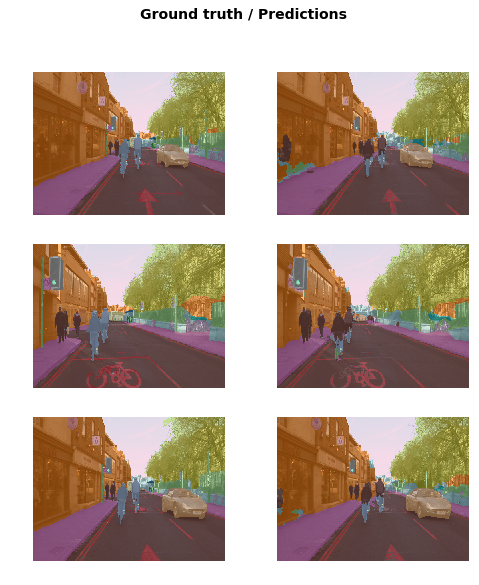

In [29]:
learn.show_results(rows=3, figsize=(8,9))

In [30]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


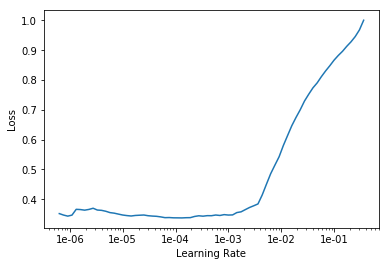

In [31]:
lr_find(learn)
learn.recorder.plot()

In [32]:
lrs = slice(lr/400,lr/4)

In [33]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.336273,0.287551,0.919192
2,0.332349,0.287009,0.919503
3,0.326247,0.277399,0.922335
4,0.314116,0.275465,0.920488
5,0.307699,0.273160,0.919014
6,0.297340,0.285362,0.915489
7,0.296455,0.284089,0.918466
8,0.292288,0.281670,0.917517
9,0.281715,0.274589,0.921777
10,0.266135,0.275933,0.922422


In [34]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [35]:
size = src_size
bs=3

In [36]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [38]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [39]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


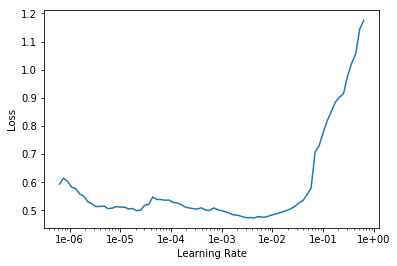

In [40]:
lr_find(learn)
learn.recorder.plot()

In [41]:
lr=1e-3

In [42]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.385681,0.318373,0.910565
2,0.366705,0.293300,0.919590
3,0.332642,0.297203,0.917243
4,0.327490,0.272018,0.921187
5,0.319573,0.276395,0.922740
6,0.333387,0.311028,0.912638
7,0.304866,0.289681,0.917859
8,0.289343,0.273665,0.926244
9,0.265038,0.260927,0.927239
10,0.226561,0.248692,0.932544


In [43]:
learn.save('stage-1-big')

In [44]:
learn.load('stage-1-big');

In [45]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


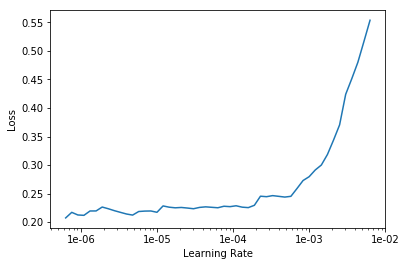

In [46]:
lr_find(learn)
learn.recorder.plot()

In [47]:
lrs = slice(1e-6,lr/10)

In [48]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.214240,0.249960,0.931747
2,0.218593,0.247285,0.930751
3,0.209614,0.260241,0.929865
4,0.218147,0.247365,0.933282
5,0.199037,0.241541,0.933604
6,0.205003,0.249834,0.931329
7,0.209118,0.251481,0.932254
8,0.200736,0.252815,0.931516
9,0.191695,0.249487,0.931844
10,0.187268,0.249613,0.931859


In [49]:
learn.save('stage-2-big')

In [50]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;
Train: LabelList
y: SegmentationLabelList (600 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images
x: SegmentationItemList (600 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images;
Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images
x: SegmentationItemList (101 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/jupyter/.fastai/data/camvid/images;
Test: None, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), st

In [52]:
from my_python_tricks import *
notify_me()

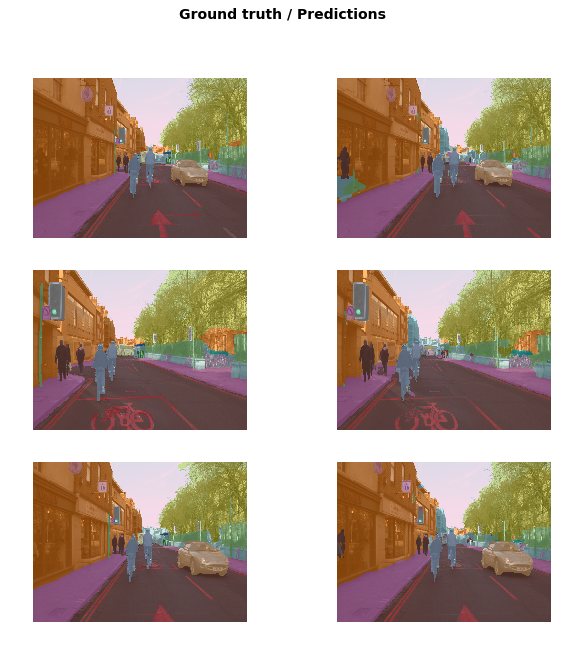

In [53]:
learn.show_results(rows=3, figsize=(10,10))

## fin